In [1]:
from pyscf import gto, scf
import pyscf.qmmm
import pyscf.dft
import numpy as np
angstrom = 1 / 0.52917721067
from matplotlib import pyplot as plt
from functools import reduce
from numpy.linalg import inv 
# ancora il modo migliore per mettere cariche frazionali sulle molecole, se vai a toccare mol.charges si incazza 
#  quando deve calcolare l' initial guess 

def fc(calc,deltaZ):
    mf = pyscf.qmmm.mm_charge(calc, calc.mol.atom_coords()/angstrom, deltaZ)
    class NoSelfQMMM(mf.__class__):
        def energy_nuc(self):
            q = self.mol.atom_charges().astype(np.float)
            for i in range (len(q)):
                q[i] += deltaZ[i] 
            return self.mol.energy_nuc(q)
    return(NoSelfQMMM())

def DeltaV(mol,dL):
    mol.set_rinv_orig_(mol.atom_coords()[0])
    dV=mol.intor('int1e_rinv')*dL[0]
    mol.set_rinv_orig_(mol.atom_coords()[1]/angstrom)
    dV+=mol.intor('int1e_rinv')*dL[1]
    return dV

In [2]:
molCO=gto.Mole(atom="C 0 0 0 ; O 0 0 1.06",basis="sto-3G")# basis={'C': gto.basis.load("sto-3G ",'N'),'O': gto.basis.load("sto-3G ",'N')})
molCO.build()
hf=scf.RHF(molCO)
hfnn=fc(hf,[1.,-1])
hf.scf()
hfnn.scf()

converged SCF energy = -111.200776611731
converged SCF energy = -105.427838127191


-105.42783812719127

-105.42783812719127

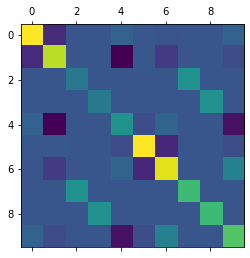

In [3]:
plt.matshow(hf.make_rdm1())
hfnn.e_tot

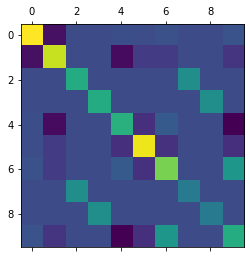

In [4]:
plt.matshow(hfnn.make_rdm1())

In [5]:
print(dir(hf))

['CASCI', 'CASSCF', 'CCSD', 'CISD', 'DFMP2', 'DIIS', 'Gradients', 'MP2', 'QMMM', 'TDA', 'TDHF', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_chkfile', '_eigh', '_eri', '_finalize', '_is_mem_enough', '_keys', '_t0', '_w0', 'analyze', 'apply', 'as_scanner', 'build', 'callback', 'canonicalize', 'check_convergence', 'check_sanity', 'chkfile', 'conv_check', 'conv_tol', 'conv_tol_grad', 'converged', 'convert_from_', 'damp', 'damp_factor', 'density_fit', 'diis', 'diis_file', 'diis_space', 'diis_space_rollback', 'diis_start_cycle', 'dip_moment', 'direct_scf', 'direct_scf_tol', 'dump_chk', 'dump_flags', 'e_tot', 'eig', 'energy_elec', 'energy_nuc', 'energy_tot', 'from_chk', 'get_fock', 'get_grad', 'g

In [16]:
S=hf.get_ovlp()
C=hf.mo_coeff
O1=hf.mo_occ
O=np.diag(O1)
P=hf.make_rdm1()
F=hf.get_fock()
h1=hf.get_hcore()
h2=hf.get_veff()
J,K=hf.get_jk()
g_ijkl=hf.mol.intor('int2e_sph')
E=np.diag(hf.mo_energy)
print('COC* = P :', np.allclose(P,C.dot(O.dot(C.T)))) 
print( "J-K/2 = H2 :",np.allclose(h2,J-K/2))
print("J= sum_ij(g_ijklm P_lm ) ",np.allclose(J,np.einsum('ijkl,kl->ij',g_ijkl,P)))
print("K= sum_ik(g_ijklm P_jm ) ",np.allclose(K,np.einsum('ijkl,jl->ik',g_ijkl,P)))

print( "F= H1 +H2 :",np.allclose(F,h1+h2))
print ("numero di elettroni:", S.dot(P).trace())  # numero di elettroni
print("FC=SCE :",np.allclose(np.dot(F,C),S.dot(C.dot(E))))
print("eig(S-1 F) -> C,E ","np.linalg.eig(np.linalg.inv(S).dot(F))" )
print("C*FC = E : ",np.allclose(C.T.dot(F.dot(C))/100,E/100))


COC* = P : True
J-K/2 = H2 : True
J= sum_ij(g_ijklm P_lm )  True
K= sum_ik(g_ijklm P_jm )  True
F= H1 +H2 : True
numero di elettroni: 13.999999999999996
FC=SCE : True
eig(S-1 F) -> C,E  np.linalg.eig(np.linalg.inv(S).dot(F))
C*FC = E :  True


6.598497947169522

$$ J - K/2 =H_2$$
$$H_1+ H_2 = F $$

$$ V_{ij}^{\alpha} = \sum_{kl} (ij|kl)(\gamma_{lk}^\alpha+\gamma_{lk}^\beta)- \sum_{kl} (il|kj) \gamma_{lk}^{\alpha} \\    V_{ij}^{\beta}  = \sum_{kl} (ij|kl)(\gamma_{lk}^{\alpha}+\gamma_{lk}^{\beta})  - \sum_{kl} (il|kj)\gamma_{lk}^\beta $$

Now getting the energies

$$  E = \sum_{ij}h_{ij} \gamma_{ji} + \frac{1}{2}\sum_{ijkl} \gamma_{ji}\gamma_{lk} \langle ik||jl\rangle $$


In [7]:
e_tot=hf.e_tot 
e_nn=hf.energy_nuc() 
e_ne,e_ee=hf.energy_elec()
e_ne-=e_ee

In [8]:
print(e_tot,e_nn+e_ee+e_ne)
print(e_ne,np.trace(P.dot(h1)))
print(e_ee,np.trace(P.dot(h2))/2)

-111.20077661173107 -111.20077661173106
-199.44865984435546 -199.44865984435552
64.28514160605836 64.28514160605836


Now is to get the alchemical derivatives:
$$ $$

In [58]:
hf0=fc(hf,[.005,-.005])
hf0.scf()
C0=hf0.mo_coeff
P0=hf0.make_rdm1()

hf1=fc(hf,[-.005,.005])
hf1.scf()
C1=hf1.mo_coeff
P1=hf1.make_rdm1()

converged SCF energy = -111.164393070353
converged SCF energy = -111.237233395315


In [59]:
dC=(C1-C0)/.01
U=np.dot(np.linalg.inv(C),dC)
dP=(P1-P0)/.01

In [60]:
print(np.allclose(dC,C.dot(U)))
print(np.allclose(dC.T,U.T.dot(C.T)))

True
True


In [61]:
print(np.allclose(P,C.dot(O.dot(C.T))))                        #P = COC*
print(np.allclose(P0,C0.dot(O.dot(C0.T))))
print(np.allclose(P1,C1.dot(O.dot(C1.T))))
print(np.allclose(P1-P0,C1.dot(O.dot(C1.T))-C0.dot(O.dot(C0.T))))  # P1-P0 = C_1 O C_1* - C_0 O C_0*

True
True
True
True


In [62]:
print(np.allclose(P1-P0,(C1-C0).dot(O.dot(C1.T))+C0.dot(O.dot((C1-C0).T)))) 
print(np.allclose(dP,dC.dot(O.dot(C1.T))+C0.dot(O.dot(dC.T))))
print(np.allclose(dP,dC.dot(O.dot(C1.T))+C0.dot(O.dot(dC.T))))
print(np.allclose(dP,dC.dot(O.dot(C1.T))+C0.dot(O.dot(dC.T))))
print(np.linalg.norm(dP-dC.dot(O.dot(C.T))-C.dot(O.dot(dC.T))))
print(np.linalg.norm(dP-dC.dot(O.dot(C1.T))-C0.dot(O.dot(dC.T))))

True
True
True
True
65.39770815429746
5.1304619658192314e-14


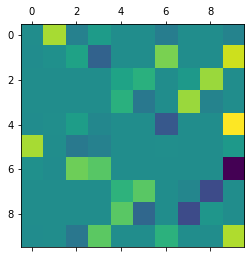

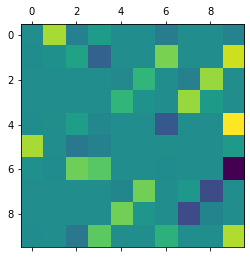

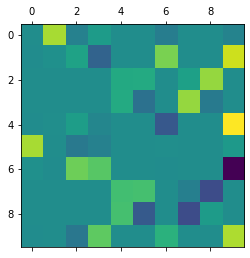

In [84]:
plt.matshow(C0)
plt.matshow(C)
plt.matshow(C1)
#C1[[7,8]]=C1[[8,7]]

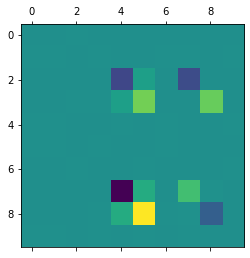

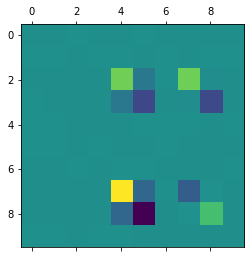

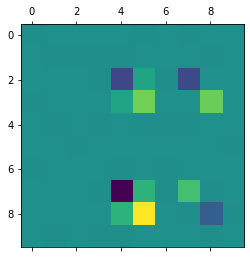

In [83]:
plt.matshow((C-C0))
plt.matshow((C1-C))
plt.matshow(((C-C1)+(C-C0))/2)


#print(np.linalg.norm((C-C0)))
#print(np.linalg.norm((C1-C)))
#print(np.linalg.norm(((C-C1)+(C-C0))/2))
#print(np.linalg.norm(C0-C1))
#
#print(np.linalg.norm(P-P0))
#print(np.linalg.norm((P1+P0)/2-P))
#print(np.linalg.norm(P-P1))

In [65]:
np.allclose(F.dot(C),S.dot(C.dot(E)))


True

In [66]:
#building B matrix
B=(hf1.get_hcore()-hf0.get_hcore())/.001
inv(B)

array([[ 2.33005955e-02, -3.99581909e-02,  0.00000000e+00,
         0.00000000e+00, -1.25603871e-02, -1.39882938e-04,
         1.53493258e-02,  0.00000000e+00,  0.00000000e+00,
        -7.18820276e-03],
       [-3.99581909e-02,  3.74645374e-01,  0.00000000e+00,
         0.00000000e+00,  1.61808032e-01, -6.33131950e-03,
        -9.04017871e-02,  0.00000000e+00,  0.00000000e+00,
        -1.77021741e-02],
       [ 0.00000000e+00,  0.00000000e+00,  2.37797807e-01,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00, -9.10168174e-03,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.37797807e-01,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00, -9.10168174e-03,
         0.00000000e+00],
       [-1.25603871e-02,  1.61808032e-01, -0.00000000e+00,
        -0.00000000e+00,  3.49257959e-01, -4.41058445e-03,
        -1.33673746e-01, -0.00000000e+00, -0.00000000e+00,
         2.

In [67]:
#Building A matrix
e=hf.mo_energy
A= np.zeros((10,10,10,10), float)
i,k = np.ogrid[:10,:10]
A[i,:,i,:]=e[i]
A[:,i,:,i]-=e[i]
A+=4*g_ijkl
for a in range(10):
    for i in range(10):
        for b in range(10):
            for j in range(10):
                A[a][i][b][j]-=g_ijkl[a][j][b][i]+g_ijkl[a][b][i][j]

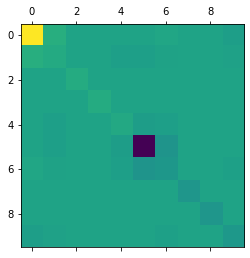

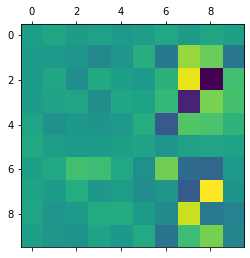

In [120]:
U_1=np.einsum('ij,ijkl->kl',inv(B),A)
plt.matshow(B)
plt.matshow(C.dot(inv(U_1)))

In [144]:
nC=C.copy()
e

array([-20.45987506, -11.10165069,  -1.5202348 ,  -0.71062586,
        -0.59778186,  -0.59778186,  -0.45123894,   0.34425119,
         0.34425119,   1.16976554])

In [143]:
nC=C.copy()
#(nC[2],nC[3])=(nC[3],nC[2])
#(nC[8],nC[7])=(nC[7],nC[8])

for i in range(10):
    print(inv(S).dot(F.dot(nC.T[i]))/nC.T[i])

[-20.45987593 -20.45987436  -1.07999347   5.30000947 -20.45987404
 -20.45987461 -20.45987498 -19.78947014 -74.96503006 -20.45987307]
[-11.10165088 -11.10164928  -6.61018095  16.54990279 -11.10164513
 -11.10165267 -11.10164626  -5.30474049  28.50243162 -11.1017092 ]
[ -1.52023486  -1.52023479  -0.4638319  168.41375222  -1.52023452
  -1.5202346   -1.52023465  -0.79254365  -0.61807808  -1.52023475]
[-0.71062601 -0.71062615  2.74582011 -0.49899991 -0.71062666 -0.71062564
 -0.71062585 -0.65452792 -0.66927478 -0.71062551]
[-0.8563031  -0.25975942 -0.59778194 -0.59778194 -0.2969178   3.56585028
 -0.56326108 -0.59778165 -0.59778165 -0.72355758]
[-4.43617757e-01 -9.08955937e-01 -5.97781940e-01 -5.97781940e-01
 -2.79666438e-02 -7.37923316e+00  2.96334517e+01 -5.97781649e-01
 -5.97781649e-01 -6.74157423e+00]
[-0.45123914 -0.45123911 -0.70506842 -1.21310372 -0.45123891 -0.45124032
 -0.4512527  -0.65844047 -0.48850079 -0.45123888]
[ 0.80380858  0.73404156  0.34425115  0.34425115  1.49364765 -7.4499